In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#!pip install scikit-learn==0.24.0

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
!pip install hdbscan
!pip install fa_kit
!pip install kneed
from fa_kit.rotation import VarimaxRotatorPython

from sklearn import metrics
import os

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model

In [2]:
def read_file(dfs):
    df = pd.DataFrame()
    path = '/home/jovyan/work/Toni/detection_of_IoT_botnet_attacks_N_BaIoT/anonymized/alex2/'+folder+'/'
    df_new = pd.read_csv(path+'benign_traffic.csv')
    df_new['label'] = 'benign_traffic'
    df = pd.concat([df,df_new], ignore_index=True)
    
    directory = os.fsencode(path+'gafgyt_attacks')
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            df_new = pd.read_csv(path+'gafgyt_attacks'+'/'+filename)
            filename=filename[:-4] 
            df_new['label'] = 'gafgyt_'+filename
            df = pd.concat([df,df_new], ignore_index=True)
    directory = os.fsencode(path+'mirai_attacks')
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            df_new = pd.read_csv(path+'mirai_attacks'+'/'+filename)
            filename=filename[:-4] 
            df_new['label'] = 'mirai_'+filename
            df = pd.concat([df,df_new], ignore_index=True)
    return df

In [3]:
folder = 'baby_k50_e10_lof'
df = read_file(folder)
df = df.dropna().reset_index(drop=True)

In [4]:
def pca_func(rate, data):    
    df_wo_label = data.drop(columns = ['label'])
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_wo_label)
    pca = PCA(n_components=rate, random_state=0)
    pca_comp = pca.fit(data_scaled).components_
    return pca_comp, data_scaled

In [5]:
# LEts transform our original dataset to lower dimensional
def decrease_dim(components, data_scaled):
    varimax = VarimaxRotatorPython()
    rotated_weights = varimax.rotate(components.T)
    df_lowdim = pd.DataFrame(np.dot(data_scaled, rotated_weights))
    #df_lowdim["label"] = df["label"]
    rotated_data = np.dot(data_scaled, rotated_weights)
    return df_lowdim, rotated_data

In [6]:
import scipy.special

def adj_rand(data):
    tab = pd.crosstab(data['label'], data['cluster_label'])
    df_tab = pd.DataFrame(tab)
    a = list(df_tab.sum(axis=1))
    b = list(df_tab.sum(axis=0))
    n = df_tab.values.tolist()
    sum_n = 0
    for i in range(len(n)):
        for j in range(len(n[0])):
            sum_n += scipy.special.comb(n[i][j],2)
    sum_a = 0
    for k in range(len(a)):
        sum_a += scipy.special.comb(a[k],2)
    sum_b = 0
    for l in range(len(b)):
        sum_b += scipy.special.comb(b[l],2)
    
    ari = (sum_n - sum_a*sum_b/scipy.special.comb(sum(a),2))/(0.5*(sum_a+sum_b)-sum_a*sum_b/scipy.special.comb(sum(a),2))
    return(ari)

In [7]:
def evall(df_cl):
    sc = []
    sc.append(metrics.rand_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(adj_rand(df_cl))
    sc.append(metrics.mutual_info_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.adjusted_mutual_info_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.homogeneity_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.completeness_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.v_measure_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.fowlkes_mallows_score(df_cl['label'], df_cl['cluster_label']))
    return sc

In [8]:
def L_method_optimum(tofit, minima=0):
    maxima = len(tofit)
    # minima=0
    regr = linear_model.LinearRegression()
    x_axis=np.arange(minima,maxima)
    mse=np.zeros(maxima-minima)
    xo =np.zeros(maxima-minima)
    for i in range(2,maxima-minima-2):
        #print(i)
        guess11=regr.fit(x_axis[i:].reshape(-1, 1),tofit[i:].reshape(-1, 1)).predict(x_axis[i:].reshape(-1, 1))
        guess1= regr.fit(x_axis[i:].reshape(-1, 1),tofit[i:].reshape(-1, 1))
        a= guess1.coef_
        b= guess1.intercept_
        guess22=regr.fit(x_axis[:i].reshape(-1, 1),tofit[:i].reshape(-1, 1)).predict(x_axis[:i].reshape(-1, 1))
        guess2 =regr.fit(x_axis[:i].reshape(-1, 1),tofit[:i].reshape(-1, 1))
        c= guess2.coef_
        d= guess2.intercept_
        mse[i]= (maxima-minima-i+1)*mean_squared_error(tofit[i:], guess11 )+i*mean_squared_error(tofit[:i], guess22)
        xo[i]=(d-b)/(a-c)
        min_place=np.argmin(mse[2:-2])+2+minima
    #labels = hierarchy.fcluster(linkage, minhely, 'maxclust')
    return (min_place) #, distances[min_place])

In [9]:
df_eval = pd.DataFrame(columns = ['rand_score', 'adjusted_rand_score', 'mutual_info_score', 'adjusted_mutual_info_score', 
                                  'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score'])

# K-MEANS

In [10]:
def kmeans(low_data, num_cl):
    low_data_2 = low_data.copy()
    kmeans = KMeans(init="random",n_clusters=num_cl,n_init=10,max_iter=200,random_state=42)
    kmeans.fit(low_data_2)
    low_data_2["cluster_label"] = kmeans.labels_
    low_data_2["label"] = df["label"]
    return low_data_2

In [11]:
comp, df_scaled = pca_func(0.7, df)
df_low, np_low = decrease_dim(comp, df_scaled)

In [12]:
kmeans_kwargs = {"init": "random","n_init": 10, "max_iter": 200,"random_state": 42}

sse = []
for k in range(1, 100):
    print(k)
    kmeanss =  MiniBatchKMeans(n_clusters=k, **kmeans_kwargs)
    kmeanss.fit(df_low)
    sse.append(kmeanss.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


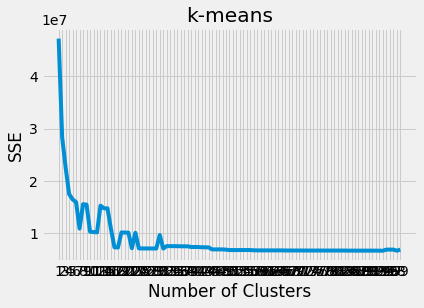

In [13]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 100), sse)
plt.xticks(range(1, 100))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('k-means')
plt.show()

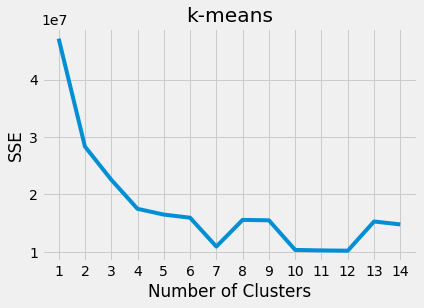

In [14]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse[:14])
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('k-means')
plt.show()

In [15]:
sse = np.array(sse)
L_method_optimum(sse)

4

In [16]:
for k in range(3,13):
    print(k)
    df_kmeans = kmeans(df_low, k)
    df_eval.loc['kmeans_cl'+str(k)]=evall(df_kmeans)

3
4
5
6
7
8
9
10
11
12


In [17]:
df_eval.to_csv('eval_baby_k50_e10_lof')

# MINIBATCH KMEANS

In [18]:
def minibatch(low_data, num_cl):
    low_data_2 = low_data.copy()
    mini_kmeans = MiniBatchKMeans(init="random",n_clusters=num_cl,n_init=10,max_iter=200,random_state=42)
    mini_kmeans.fit(low_data_2)
    low_data_2["cluster_label"] = mini_kmeans.labels_
    low_data_2["label"] = df["label"]
    return low_data_2

In [19]:
comp, df_scaled = pca_func(0.7, df)
df_low, np_low = decrease_dim(comp, df_scaled)

kmeans_kwargs = {"init": "random","n_init": 10, "max_iter": 200,"random_state": 42}

# A list holds the SSE values for each k
sse = []
for k in range(1, 100):
    print(k)
    kmeanss =  MiniBatchKMeans(n_clusters=k, **kmeans_kwargs)
    kmeanss.fit(df_low)
    sse.append(kmeanss.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


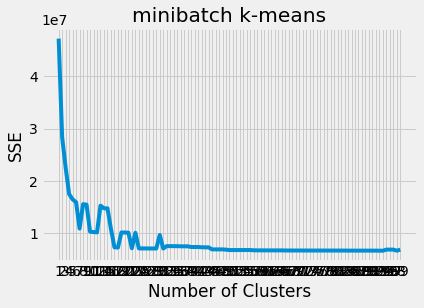

In [20]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 100), sse)
plt.xticks(range(1, 100))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('minibatch k-means')
plt.show()

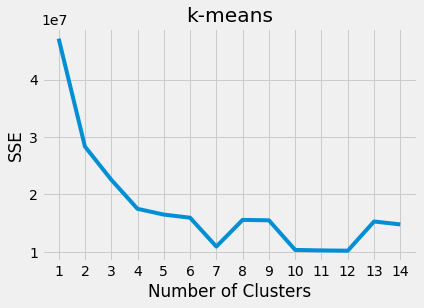

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse[:14])
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('k-means')
plt.show()

In [22]:
sse = np.array(sse)
L_method_optimum(sse)

4

In [23]:
for k in range(3,13):
    print(k)
    df_kmeans = minibatch(df_low, k)
    df_eval.loc['minibatch_kmeans_cl'+str(k)]=evall(df_kmeans)

3
4
5
6
7
8
9
10
11
12


In [24]:
df_eval.to_csv('eval_baby_k50_e10_lof')

# HIERARCHICAL

In [8]:
def hierarch(low_data, num_clust, link):
    low_data_2 = low_data.copy()
    hier = AgglomerativeClustering(n_clusters=num_clust, linkage=link).fit(low_data_2)
    low_data_2["cluster_label"] = hier.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [9]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (0.24.1)


In [11]:
df_reduced = df.sample(n=100000)
reduced_label = df_reduced['label'].reset_index(drop=True)
comp, df_scaled = pca_func(0.7, df_reduced)
df_low, np_low = decrease_dim(comp, df_scaled)

In [ ]:
for k in range(5, 6):
    print(k)
    df_hierarch = hierarch(df_low, k, 'ward')
    print(evall(df_hierarch))

5


# MEAN-SHIFT

In [28]:
def mean_shift(low_data):
    low_data_2 = low_data.copy()
    mean_sh = MeanShift().fit(low_data_2)
    low_data_2["cluster_label"] = mean_sh.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [29]:
df_meanshift = mean_shift(df_low)
df_eval.loc['meanshift']=evall(df_meanshift)
df_eval.to_csv('eval_baby_k50_e10_lof')

# DBSCAN

In [30]:
def dbscan(low_data, ep, min_samp):
    low_data_2 = low_data.copy()
    dbsc = DBSCAN(eps=ep, min_samples=min_samp).fit(low_data_2)
    low_data_2["cluster_label"] = dbsc.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

Text(0, 0.5, 'Distance')

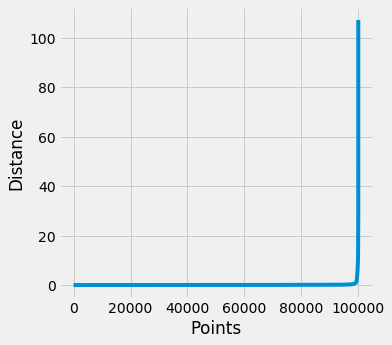

In [31]:
#estimating epsilon

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(np_low)
distances, indices = neighbors.kneighbors(np_low)

distances = np.sort(distances[:,10], axis=0)

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

Text(0, 0.5, 'Distance')

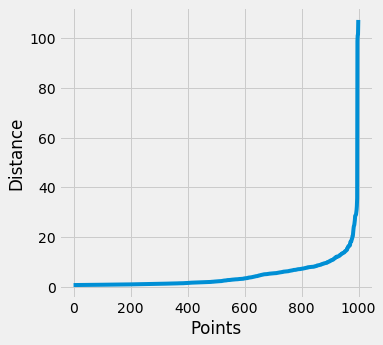

In [32]:
fig = plt.figure(figsize=(5, 5))
plt.plot(distances[99000:100000])
plt.xlabel("Points")
plt.ylabel("Distance")

In [33]:
eval_dbscan = []
for j in [0.18,0.19,0.2,0.21,0.22, 0.23, 0.24]:
    print(j)
    df_dbscan = dbscan(df_low, j, 10)
    metrics_dbscan = evall(df_dbscan)
    eval_dbscan.append(metrics_dbscan)

0.18
0.19
0.2
0.21
0.22
0.23
0.24


In [34]:
eval_dbscan

[[0.9138703163031631,
  0.5931689650458355,
  1.7711982408446059,
  0.7800883505986387,
  0.7872164632067158,
  0.7735052329030548,
  0.7803006202010312,
  0.6422595056287912],
 [0.9142722861228613,
  0.5960090200397037,
  1.7727392879086568,
  0.7824833902870094,
  0.7879013880171756,
  0.7775421966958067,
  0.7826875168176342,
  0.6449230618555726],
 [0.914500651406514,
  0.5973822751988015,
  1.7757967130883612,
  0.7837777780279155,
  0.7892602734208435,
  0.7787815503430003,
  0.7839858989008656,
  0.6461839435541029],
 [0.90320039100391,
  0.562893606181264,
  1.6722931051429313,
  0.7567047870429936,
  0.7432576621394086,
  0.7710844764703307,
  0.7569154033044113,
  0.6195845424125421],
 [0.9032978199781998,
  0.5636954879282363,
  1.6741629877840747,
  0.7579252712649518,
  0.7440887392969099,
  0.7727694151868678,
  0.7581579308703333,
  0.6203719489113703],
 [0.9034680468804688,
  0.5647476889472494,
  1.675778109056809,
  0.7588324914827774,
  0.74480658669911,
  0.77387635

In [44]:
eval_dbscan = []
for i in [3,4,5,6]:
    df_dbscan = dbscan(df_low, 0.20, i)
    metrics_dbscan = evall(df_dbscan)
    eval_dbscan.append(metrics_dbscan)

In [45]:
eval_dbscan

[[0.9153576099760997,
  0.6032105267827701,
  1.7923224868415382,
  0.787267949668936,
  0.7966052226567499,
  0.7795249300244759,
  0.7879725280203146,
  0.6516392456648071],
 [0.9153311849118492,
  0.6029348164082518,
  1.79009957102899,
  0.7880396320411639,
  0.7956172384302491,
  0.781606364383237,
  0.7885495703473006,
  0.6513683928561664],
 [0.9151441030410304,
  0.601801486915983,
  1.7878788515041804,
  0.7881119620970491,
  0.7946302303530159,
  0.7824595215556979,
  0.7884979140891714,
  0.6503242814994332],
 [0.914959439394394,
  0.6002976416075907,
  1.7871814597460112,
  0.7869781243575793,
  0.7943202716704274,
  0.7805014000596401,
  0.787350206393131,
  0.6488847121421101]]

In [2]:
df_dbscan = dbscan(df_low, 0.20, 10)

NameError: name 'dbscan' is not defined

In [38]:
#evall(df_dbscan)

In [47]:
df_eval.loc['dbscan(0.2,4)']=evall(df_dbscan)
df_eval.to_csv('eval_baby_k50_e10_lof')

# OPTICS

In [40]:
def optics(low_data):
    low_data_2 = low_data.copy()
    opti = OPTICS().fit(low_data_2)
    low_data_2["cluster_label"] = opti.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [41]:
df_optics = optics(df_low)
df_eval.loc['optics']=evall(df_optics)
df_eval.to_csv('eval_baby_k50_e10_lof')

In [42]:
df_eval

,rand_score,adjusted_rand_score,mutual_info_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score
kmeans_cl3,0.708167,0.254450,0.797189,0.481296,0.354179,0.750769,0.481302,0.447896
kmeans_cl4,0.709468,0.255375,0.809924,0.486464,0.359837,0.750643,0.486473,0.448082
kmeans_cl5,0.730862,0.266567,0.937731,0.533823,0.416620,0.742820,0.533833,0.445596
kmeans_cl6,0.730613,0.266749,0.936603,0.533396,0.416119,0.742772,0.533409,0.446013
kmeans_cl7,0.834359,0.423827,1.227461,0.642491,0.545342,0.781785,0.642501,0.538582
kmeans_cl8,0.834244,0.423017,1.228033,0.641975,0.545596,0.779744,0.641987,0.537723
kmeans_cl9,0.850197,0.455398,1.338105,0.679903,0.594500,0.793993,0.679915,0.558139
kmeans_cl10,0.886270,0.529067,1.474087,0.713003,0.654914,0.782427,0.713015,0.600888
kmeans_cl11,0.885754,0.525981,1.474413,0.711322,0.655059,0.778188,0.711335,0.597896
kmeans_cl12,0.883817,0.489762,1.480989,0.692879,0.657981,0.731719,0.692894,0.558672


# HDBSCAN

In [43]:
'''
def hdbscann(low_data):
    low_data_2 = low_data.copy()
    hdb = hdbscan.HDBSCAN().fit(low_data_2)
    low_data_2["cluster_label"] = hdb.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-43-107f263814b5>, line 7)

In [ ]:
df_hdbscan = hdbscann(df_low)
df_eval.loc['hdbscan']=evall(df_hdbscan)
df_eval.to_csv('eval_baby_k50_e10')

# SPECTRAL

In [ ]:
from sklearn.cluster import SpectralClustering

def spectral(low_data):
    low_data_2 = low_data.copy()
    spectra = SpectralClustering().fit(low_data_2)
    low_data_2["cluster_label"] = spectra.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [ ]:
df_spectra = spectral(df_low)
df_eval.loc['spectral']=evall(df_spectra)
df_eval.to_csv('eval_baby_k50_e10_lof')

In [ ]:
df_eval